In [1]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
from upsetplot import plot
import tiktoken
import torch

In [ ]:
bmx_d1 = (
    pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/NHANES Data/BMX_C.csv")
      .dropna(subset=["BMXBMI"])[["SEQN", "BMXBMI"]]
)

demo_d1 = (
    pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/NHANES Data/DEMO_C.csv")
      .query(
         "RIDAGEYR >= 20 and RIDAGEYR < 85 "
         "and DMDMARTL not in [77,99] "
         "and (RIDEXPRG in [2,3] or RIDEXPRG.isna()) "
         "and DMDEDUC2 not in [7,9]"
      )
      .dropna(subset=[
         "SEQN","RIAGENDR","RIDAGEYR",
         "RIDRETH1","DMDEDUC2","DMDMARTL","INDFMPIR"
      ])
      [["SEQN","RIAGENDR","RIDAGEYR",
        "RIDRETH1","DMDEDUC2","DMDMARTL","INDFMPIR"]]
)

paxraw_d1 = (
    pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/NHANES Data/paxraw_c.csv")
      .query("PAXSTAT == 1 and PAXCAL == 1")
      .dropna(subset=["PAXINTEN"])
      [["SEQN","PAXN","PAXINTEN"]]
)

# NHANES 2005–2006
bmx_d2 = (
    pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/NHANES Data/BMX_D.csv")
      .dropna(subset=["BMXBMI"])[["SEQN","BMXBMI"]]
)

demo_d2 = (
    pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/NHANES Data/DEMO_D.csv")
      .query(
         "RIDAGEYR >= 20 and RIDAGEYR < 85 "
         "and DMDMARTL not in [77,99] "
         "and (RIDEXPRG in [2,3] or RIDEXPRG.isna()) "
         "and DMDEDUC2 not in [7,9]"
      )
      .dropna(subset=[
         "SEQN","RIAGENDR","RIDAGEYR",
         "RIDRETH1","DMDEDUC2","DMDMARTL","INDFMPIR"
      ])
      [["SEQN","RIAGENDR","RIDAGEYR",
        "RIDRETH1","DMDEDUC2","DMDMARTL","INDFMPIR"]]
)

paxraw_d2 = (
    pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/NHANES Data/paxraw_d.csv")
      .query("PAXSTAT == 1 and PAXCAL == 1")
      .dropna(subset=["PAXINTEN"])
      [["SEQN","PAXN","PAXINTEN"]]
)

# Drop subjects missing a full week
full_week = 24 * 60 * 7

missing1 = paxraw_d1.groupby("SEQN").size().loc[lambda s: s != full_week].index
missing2 = paxraw_d2.groupby("SEQN").size().loc[lambda s: s != full_week].index

def preprocess_pax(paxraw, missing_seqn, bmx, demo):
    df = (
        paxraw.assign(min5 = ((paxraw.PAXN - 1) // 5) + 1)
              .groupby(["SEQN","min5"], as_index=False)["PAXINTEN"]
              .mean()
              .rename(columns={"PAXINTEN":"intensity"})
    )
    df = df[~df.SEQN.isin(missing_seqn)]
    return df.merge(bmx, on="SEQN").merge(demo, on="SEQN")

data1 = preprocess_pax(paxraw_d1, missing1, bmx_d1, demo_d1)
data2 = preprocess_pax(paxraw_d2, missing2, bmx_d2, demo_d2)

data = pd.concat([data1, data2], ignore_index=True)

# rename columns
data = data.rename(columns={
    "min5":"Time", "RIAGENDR":"Gender", "RIDAGEYR":"Age",
    "RIDRETH1":"Race", "DMDEDUC2":"Education",
    "DMDMARTL":"Married", "INDFMPIR":"PIR"
})

data["BMI"] = (data.BMXBMI >= 25).astype(int)

# PA categories
conds = [
    data.intensity < 100,
    data.intensity < 760,
    data.intensity < 2200,
    data.intensity < 6000,
]
choices = [0,1,2,3]
data["PA"] = np.select(conds, choices, default=4)

# pivot to wide
wide = (
    data.drop(columns=["BMXBMI","intensity"])
        .pivot_table(
            index=["SEQN","BMI","Gender","Age","Race","Education","Married","PIR"],
            columns="Time",
            values="PA"
        )
        .add_prefix("Time")
        .reset_index()
)

OSError: Cannot save file into a non-existent directory: 'E:/EntroLLM'

In [ ]:
df = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/data_wide.csv", index_col=0)

In [25]:
time_columns = [col for col in df.columns if col.startswith('Time')]

df[time_columns] = df[time_columns].astype(str)

def combine(row):
    combined_values = ' '.join(row[col] for col in time_columns)
    return combined_values

df['combined'] = df.apply(combine, axis=1)

/var/folders/dz/ggx10pdx1p91s2hsnvsw_sy40000gn/T/ipykernel_45009/2610889962.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['combined'] = df.apply(combine, axis=1)


In [28]:
embedding_encoding = "cl100k_base"
encoding = tiktoken.get_encoding(embedding_encoding)
df["n_tokens"] = df.combined.apply(lambda x: len(encoding.encode(x)))

/var/folders/dz/ggx10pdx1p91s2hsnvsw_sy40000gn/T/ipykernel_45009/3824746441.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["n_tokens"] = df.combined.apply(lambda x: len(encoding.encode(x)))


In [30]:
df = df.drop(columns=[col for col in df.columns if col.startswith('Time')])

In [34]:
df = df.reset_index()

In [49]:
def get_embedding(text, model="text-embedding-3-small"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[ 0].embedding

embedding_model = "text-embedding-3-small"
embedding_encoding = "cl100k_base"
max_tokens = 8191  # the maximum for text-embedding-3-small is 8191

df_gpt=df.copy()
df_gpt["embedding"] = df_gpt.combined.apply(lambda x: get_embedding(x, model=embedding_model))
df_gpt.to_csv("/Users/rheajaisinghani/Desktop/OTC/data_wide_embedding_gpt1536.csv")
 
# df_gpt = df_gpt[[col for col in df.columns if not col.startswith('n_tokens') and not col.startswith('Time')]]

In [54]:
df = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/data_wide_embedding_gpt1536.csv")

In [57]:
# Read in the CSV and drop the unwanted columns
df = df.drop(columns=["combined", 'n_tokens', 'Unnamed: 0'])

# Remove leading “[" and trailing “]” from the embedding string
df["embedding"] = df["embedding"].str.replace(r"[\[\]]", "", regex=True)

# Split the embedding into 1,536 separate columns named var1…var1536
emb_cols = [f"var{i}" for i in range(1, 1537)]
emb_df = (
    df["embedding"]
      .str
      .split(r",\s*", expand=True)
      .rename(columns=dict(enumerate(emb_cols, start=0)))
      .astype(float)
)

# Drop the original embedding column and concat the new numeric columns
df = pd.concat([df.drop(columns=["embedding"]), emb_df], axis=1)

# Ensure these demographic columns are strings (object dtype)
for col in ["Gender", "Race", "Education", "Married"]:
    df[col] = df[col].astype(str)

In [59]:
df.to_csv("/Users/rheajaisinghani/Desktop/OTC/data_wide_embedding_gpt1536_clean.csv")

In [42]:
gpt50 = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/Embeddings/data_wide_embedding_gpt50.csv")
#gpt1536 = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/Embeddings/data_wide_embedding_gpt1536.csv")

In [2]:
# Bring in activity data
activity1 = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/NHANES Data/paxraw_d.csv")
activity2 = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/NHANES Data/paxraw_c.csv")

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [8]:
selected_columns = ['SEQN','PAXSTAT','PAXCAL','PAXDAY','PAXINTEN','PAXN','PAXMINUT','PAXHOUR']

activity1 = activity1[selected_columns]
activity2 = activity2[selected_columns]

activity_df = pd.concat([activity1, activity2], ignore_index=True)

In [9]:
activity_in_embeddings = activity_df[activity_df['SEQN'].isin(gpt50['SEQN'])]

activity_in_embeddings.to_csv('/Users/rheajaisinghani/Desktop/OTC/activity_study.csv', index=False)

In [4]:
activity_in_embeddings = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/activity_study.csv")

low_activity = activity_in_embeddings[activity_in_embeddings['PAXINTEN'] < 500]

In [4]:
hours_low_activity = (activity_in_embeddings[low_activity].groupby('SEQN', 'PAXDAY').size()/60)

: 

In [ ]:
avg_hours_low_activity = hours_low_activity.groupby('SEQN').mean()

In [ ]:
sedentary_participants = avg_hours_low_activity[avg_hours_low_activity >= 10.6]['SEQN'].values

In [ ]:
print(f"Number of sedentary participants (>10.6 hours low activity): {len(sedentary_participants)}")

### Archive:

In [4]:
# Bring in demographics data to select for age
demo1 = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/DEMO_D.csv")
demo2 = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/DEMO_C.csv")

In [5]:
demo_shared_columns = demo1.columns.intersection(demo2.columns)

demo1 = demo1[demo_shared_columns]
demo2 = demo2[demo_shared_columns]

demo_df = pd.concat([demo1, demo2], ignore_index=True)

In [6]:
complete_age_df = demo_df[
    (demo_df['RIDAGEYR'] >= 20) & 
    (demo_df['RIDAGEYR'] < 85) & 
    (demo_df['DMDMARTL'] != 77) & 
    (demo_df['DMDMARTL'] != 99) & 
    (demo_df['RIDEXPRG'].isin([2, 3])| demo_df['RIDEXPRG'].isnull()) & 
    (demo_df['DMDEDUC2'] != 7) & 
    (demo_df['DMDEDUC2'] != 9)
]

print(f"There are {complete_age_df.SEQN.nunique()} participants with all age data given the exclusions.")

There are 9039 participants with all age data given the exclusions.


In [9]:
# Clean activity data to select for reliable and calibrated data
clean_activity = activity_df[(activity_df['PAXSTAT']==1.0) & (activity_df['PAXCAL']==1.0)]

In [10]:
filtered_activity = clean_activity[clean_activity['SEQN'].isin(gpt50['SEQN'])]

In [4]:
thresholds = list(range(0, 8005, 5))

In [13]:
results = {}

# For each SEQN
for seqn in filtered_activity['SEQN'].unique():
    # Get PAXINTEN values for this SEQN
    pax_values = filtered_activity[filtered_activity['SEQN'] == seqn]['PAXINTEN']
    
    # Count values at or above each threshold
    counts = {threshold: (pax_values > threshold).sum() for threshold in thresholds}
    
    # Add to results dictionary
    results[seqn] = counts

# Convert results to DataFrame
oct = pd.DataFrame.from_dict(results, orient='index')
oct.to_csv("/Users/rheajaisinghani/Desktop/OTC/oct_raw.csv")

# Verify the results
print("Shape of oct DataFrame:", oct.shape)
print("\nFirst few rows and columns:")
print(oct.iloc[:5, :10])

Shape of oct DataFrame: (6943, 1601)

First few rows and columns:
           0     5     10    15    20    25    30    35    40    45
31131.0  5231  4826  4572  4411  4247  4092  3960  3848  3747  3656
31132.0  3238  3013  2919  2853  2790  2728  2671  2623  2571  2531
31144.0  1980  1719  1570  1459  1379  1304  1257  1213  1163  1123
31150.0  5159  4796  4595  4424  4309  4182  4090  4017  3943  3872
31151.0  4488  4069  3852  3682  3539  3407  3282  3174  3093  3018


convert to some type of spline? 
extract slope/measure of pace of decline for each window in oct

want to model similar to raw accelerometer embeddings (time on x)

use slope/magnitude instead of entropy (from entrollm)

split activity level into low moderate, high and measure slope and magnitude within that bin (6 covariates)


In [12]:
oct = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/oct_raw.csv")

In [13]:
oct = oct.set_index(oct.columns[0])

In [15]:
oct = oct.rename_axis(None) 

In [9]:
oct.columns = [f'threshold_{x}' for x in thresholds]

In [ ]:
oct_str = oct.astype(str)

oct['concatenated'] = oct_str.apply(lambda row: ' '.join(row), axis=1)

print("First few rows of concatenated column:")
print(oct['concatenated'].head())

print("\nLength of first few concatenated strings:")
print(oct['concatenated'].str.len().head())

First few rows of concatenated column:
31131.0    5231 4826 4572 4411 4247 4092 3960 3848 3747 3...
31132.0    3238 3013 2919 2853 2790 2728 2671 2623 2571 2...
31144.0    1980 1719 1570 1459 1379 1304 1257 1213 1163 1...
31150.0    5159 4796 4595 4424 4309 4182 4090 4017 3943 3...
31151.0    4488 4069 3852 3682 3539 3407 3282 3174 3093 3...
Name: concatenated, dtype: object

Length of first few concatenated strings:
31131.0    4585
31132.0    5372
31144.0    4362
31150.0    4157
31151.0    4140
Name: concatenated, dtype: int64


In [18]:
embedding_encoding = "cl100k_base"
encoding = tiktoken.get_encoding(embedding_encoding)
oct["n_tokens"] = oct.concatenated.apply(lambda x: len(encoding.encode(x)))

In [22]:
oct_token = oct.drop(columns=[col for col in oct.columns if col.startswith('threshold')])
oct_token.to_csv("/Users/rheajaisinghani/Desktop/OTC/otc_data_wide_embedding_initial.csv")


In [14]:
from openai import OpenAI
api_key = ''
client = OpenAI(api_key=api_key)

In [24]:
def get_embedding(text, model="text-embedding-3-small"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[ 0].embedding

embedding_model = "text-embedding-3-small"
embedding_encoding = "cl100k_base"
max_tokens = 8191

In [25]:
df_gpt=oct_token.copy()
df_gpt["embedding"] = df_gpt.concatenated.apply(lambda x: get_embedding(x, model=embedding_model))

In [26]:
df_gpt = df_gpt.drop('concatenated', axis=1)

In [27]:
df_gpt.to_csv("/Users/rheajaisinghani/Desktop/OTC/data_otc_correct_embedding_gpt1536.csv")

In [34]:
def normalize_l2(x):
    emb = np.array(x)
    norm = np.linalg.norm(emb)
    if norm == 0:
        return emb
    return emb / norm

In [35]:
# 2) Normalize them
df_gpt["embedding_1536_norm"] = df_gpt["embedding"].apply(normalize_l2)

# 3) Convert to DataFrame columns if needed
df_emb = pd.DataFrame(df_gpt["embedding_1536_norm"].tolist())
df_emb["SEQN"] = df_gpt["SEQN"]

# Reorder so SEQN is first
cols = df_emb.columns.tolist()
df_emb = df_emb[cols[-1:] + cols[:-1]]

In [38]:
df_emb.to_csv("/Users/rheajaisinghani/Desktop/OTC/data_otc_correct_embedding_gpt1536.csv", index=False)

In [28]:
oct_token = oct_token.reset_index().rename(columns={'index': 'SEQN'})

In [29]:
df_gpt = df_gpt.reset_index().rename(columns={'index': 'SEQN'})

In [39]:
df_gpt

,SEQN,0,5,10,15,20,25,30,35,40,...,7980,7985,7990,7995,8000,n_tokens,embedding,embedding_50,embedding_50_norm,embedding_1536_norm
0,31131.0,5231,4826,4572,4411,4247,4092,3960,3848,3747,...,0,0,0,0,0,3311,"[-0.005901869852095842, 0.030304739251732826, ...","[-0.005901869852095842, 0.030304739251732826, ...","[-0.031683088481959484, 0.1626853453561669, 0....","[-0.0059018698342223315, 0.030304739159956476,..."
1,31132.0,3238,3013,2919,2853,2790,2728,2671,2623,2571,...,1,1,1,1,1,3336,"[-0.0028967258986085653, 0.0233925748616457, 0...","[-0.0028967258986085653, 0.0233925748616457, 0...","[-0.01484955663755183, 0.11991792715805004, 0....","[-0.002896725952440629, 0.023392575296367735, ..."
2,31144.0,1980,1719,1570,1459,1379,1304,1257,1213,1163,...,1,1,1,1,1,3214,"[0.0002247347729280591, 0.017335131764411926, ...","[0.0002247347729280591, 0.017335131764411926, ...","[0.0012242778547636864, 0.09443584387082755, 0...","[0.00022473477548714724, 0.01733513196180964, ..."
3,31150.0,5159,4796,4595,4424,4309,4182,4090,4017,3943,...,0,0,0,0,0,3302,"[0.002347341738641262, 0.022133635357022285, 0...","[0.002347341738641262, 0.022133635357022285, 0...","[0.012939484183027577, 0.12200942875103846, 0....","[0.0023473418479776154, 0.022133636387980386, ..."
4,31151.0,4488,4069,3852,3682,3539,3407,3282,3174,3093,...,0,0,0,0,0,3300,"[-0.0040491134859621525, 0.02270076610147953, ...","[-0.0040491134859621525, 0.02270076610147953, ...","[-0.02205416035756763, 0.12364344382476627, 0....","[-0.004049113471003708, 0.02270076601761719, 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6938,31114.0,4904,4418,4168,3956,3807,3658,3559,3455,3350,...,0,0,0,0,0,3292,"[-0.008950109593570232, 0.0250631645321846, 0....","[-0.008950109593570232, 0.0250631645321846, 0....","[-0.04897189467642008, 0.13713694127384657, 0....","[-0.008950109271560237, 0.0250631636304538, 0...."
6939,31119.0,2697,2620,2562,2511,2467,2433,2406,2377,2350,...,0,0,0,0,0,3430,"[-0.0059438482858240604, 0.02686450444161892, ...","[-0.0059438482858240604, 0.02686450444161892, ...","[-0.031243785314259406, 0.14121302714770448, 0...","[-0.005943848217097955, 0.02686450413099646, 0..."
6940,31121.0,4773,4183,3826,3635,3458,3322,3169,3043,2946,...,0,0,0,0,0,3280,"[-0.0014023869298398495, 0.025532115250825882,...","[-0.0014023869298398495, 0.025532115250825882,...","[-0.007710513426643897, 0.14037903039683503, 0...","[-0.001402386936931231, 0.025532115379932885, ..."
6941,31124.0,2517,2316,2199,2130,2083,2040,1995,1958,1929,...,0,0,0,0,0,3298,"[-0.0008422043174505234, 0.02478110045194626, ...","[-0.0008422043174505234, 0.02478110045194626, ...","[-0.004607635099970202, 0.13557549622153633, 0...","[-0.000842204272900808, 0.02478109914111117, 0..."


In [ ]:
def normalize_l2(x):
    emb = np.array(x)
    norm = np.linalg.norm(emb)
    if norm == 0:
        return emb
    return emb / norm

# 1) Truncate your existing 1536-dim embeddings to 50 dims
df_gpt["embedding_50"] = df_gpt["embedding"].apply(lambda emb: emb[:50])

# 2) Normalize them
df_gpt["embedding_50_norm"] = df_gpt["embedding_50"].apply(normalize_l2)

# 3) Convert to DataFrame columns if needed
df_emb = pd.DataFrame(df_gpt["embedding_50_norm"].tolist())
df_emb["SEQN"] = df_gpt["SEQN"]

# Reorder so SEQN is first
cols = df_emb.columns.tolist()
df_emb = df_emb[cols[-1:] + cols[:-1]]

# 4) Merge or save
df_new = pd.merge(df_gpt, df_emb, on="SEQN", how="left")
df_new.to_csv("/Users/rheajaisinghani/Desktop/OTC/data_otc_correct_embedding_gpt50.csv", index=False)

In [41]:
# 3) Convert to DataFrame columns if needed
df_emb = pd.DataFrame(df_gpt["embedding_50_norm"].tolist())
df_emb["SEQN"] = df_gpt["SEQN"]

# Reorder so SEQN is first
cols = df_emb.columns.tolist()
df_emb = df_emb[cols[-1:] + cols[:-1]]

df_emb.to_csv("/Users/rheajaisinghani/Desktop/OTC/data_otc_correct_embedding_gpt50.csv", index=False)

In [10]:
missing1 = clean_activity.groupby('SEQN').size().reset_index(name='n')
missing1 = missing1[missing1['n'] != 24 * 60 * 7]
complete_activity_df = clean_activity[~clean_activity['SEQN'].isin(missing1['SEQN'])]
complete_activity_df = complete_activity_df[complete_activity_df['SEQN'].isin(complete_age_df['SEQN'])]

print(f"There are {complete_activity_df.SEQN.nunique()} participants with all activity data.")

There are 7360 participants with all activity data.


In [11]:
bmi1 = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/BMX_D.csv")
bmi2 = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/BMX_C.csv")

In [12]:
bmi_shared_columns = bmi1.columns.intersection(bmi2.columns)

bmi1 = bmi1[bmi_shared_columns]
bmi2 = bmi2[bmi_shared_columns]

bmi_df = pd.concat([bmi1, bmi2], ignore_index=True)

In [13]:
complete_bmi_df = bmi_df.loc[bmi_df['BMXBMI'].notnull()]
complete_bmi_df = complete_bmi_df[complete_bmi_df['SEQN'].isin(complete_age_df['SEQN'])]
print(f"There are {complete_bmi_df.SEQN.nunique()} participants with all BMI data.")

There are 8464 participants with all BMI data.


In [39]:
cig1 = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/NHANES Data/SMQ_D.csv")
cig2 = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/NHANES Data/SMQ_C.csv")

In [40]:
cig_shared_columns = cig1.columns.intersection(cig2.columns)

cig1 = cig1[cig_shared_columns]
cig2 = cig2[cig_shared_columns]

cig_df = pd.concat([cig1, cig2], ignore_index=False)

In [43]:
complete_cig_df = cig_df.loc[cig_df['SMD057'].notnull()]
complete_cig_df = complete_cig_df[complete_cig_df['SEQN'].isin(gpt50['SEQN'])]

print(f"There are {complete_cig_df.SEQN.nunique()} participants with all cig data.")

There are 1664 participants with all cig data.


In [44]:
cig_risk = complete_cig_df.loc[complete_cig_df['SMD057'].isin(range(20,96)), 'SEQN']

In [47]:
cig_risk = pd.DataFrame(cig_risk)
cig_risk.to_csv("/Users/rheajaisinghani/Desktop/OTC/cig_risk.csv")

In [14]:
tv1 = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/PAQ_D.csv")
tv2 = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/PAQ_C.csv")

In [15]:
tv_shared_columns = tv1.columns.intersection(tv2.columns)

tv1 = tv1[tv_shared_columns]
tv2 = tv2[tv_shared_columns]

tv_df = pd.concat([tv1, tv2], ignore_index=False)

In [16]:
complete_tv_df = tv_df.loc[tv_df['PAD590'].notnull()]
complete_tv_df = complete_tv_df[complete_tv_df['SEQN'].isin(complete_age_df['SEQN'])]

print(f"There are {complete_tv_df.SEQN.nunique()} participants with all TV data.")

There are 9039 participants with all TV data.


In [20]:
set_activity = set(complete_activity_df['SEQN'].dropna())
set_age = set(complete_age_df['SEQN'].dropna())
set_bmi = set(complete_bmi_df['SEQN'].dropna())
set_cig = set(complete_cig_df['SEQN'].dropna())
set_tv = set(complete_tv_df['SEQN'].dropna())

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermedia

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

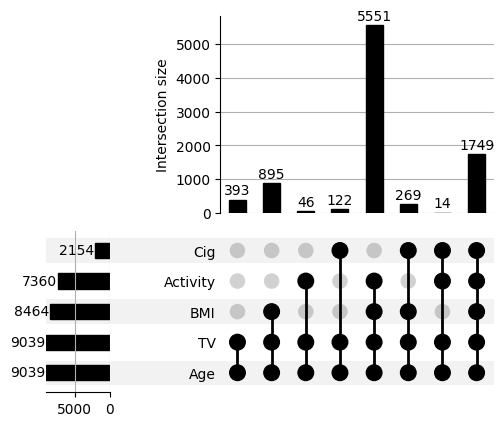

In [19]:
set_names = ['Activity', 'Age', 'BMI', 'Cig', 'TV']
all_elems = set_activity.union(set_age).union(set_bmi).union(set_cig).union(set_tv)
df = pd.DataFrame([[e in set_activity, e in set_age, e in set_bmi, e in set_cig, e in set_tv] for e in all_elems], columns = set_names)
df_up = df.groupby(set_names).size()
plot(df_up, orientation='horizontal', show_counts=True)

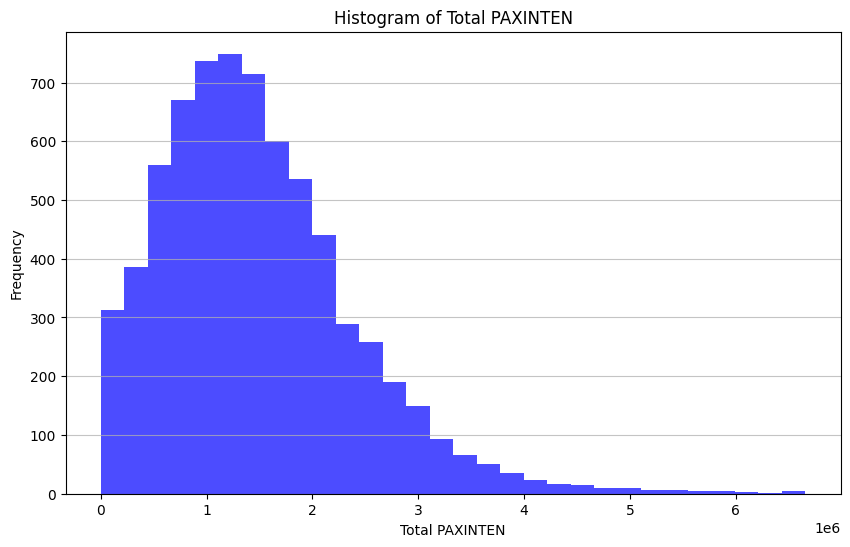

In [5]:
activity_sum_by_seqn = activity_in_embeddings.groupby('SEQN')['PAXINTEN'].sum().reset_index()
activity_sum_by_seqn.columns = ['SEQN', 'Total_PAXINTEN']

plt.figure(figsize=(10, 6))
plt.hist(activity_sum_by_seqn['Total_PAXINTEN'], bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Total PAXINTEN')
plt.xlabel('Total PAXINTEN')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [6]:
tenth_percentile = activity_sum_by_seqn['Total_PAXINTEN'].quantile(0.1)
activity_risk = activity_sum_by_seqn[activity_sum_by_seqn['Total_PAXINTEN'] <= tenth_percentile].SEQN

In [7]:
tenth_percentile

441520.0

In [19]:
demographics = complete_age_df[['SEQN', 'RIDAGEYR']]
bmi = complete_bmi_df[['SEQN', 'BMXBMI']]
tv = complete_tv_df[['SEQN', 'PAD590']]

In [20]:
data = (
    gpt50
    .merge(demographics, on='SEQN', how='inner')
    .merge(bmi, on='SEQN', how='inner')
    .merge(tv, on='SEQN', how='inner')
)

In [35]:
data['Activity_Risk'] = data['SEQN'].isin(activity_risk)

In [36]:
data['BMI_Risk'] = data['BMXBMI'] > 25

In [37]:
data['TV_Risk'] = data['PAD590'].isin([2,3,4,5])

In [39]:
data.to_csv('/Users/rheajaisinghani/Desktop/OTC/data.csv', index=False)

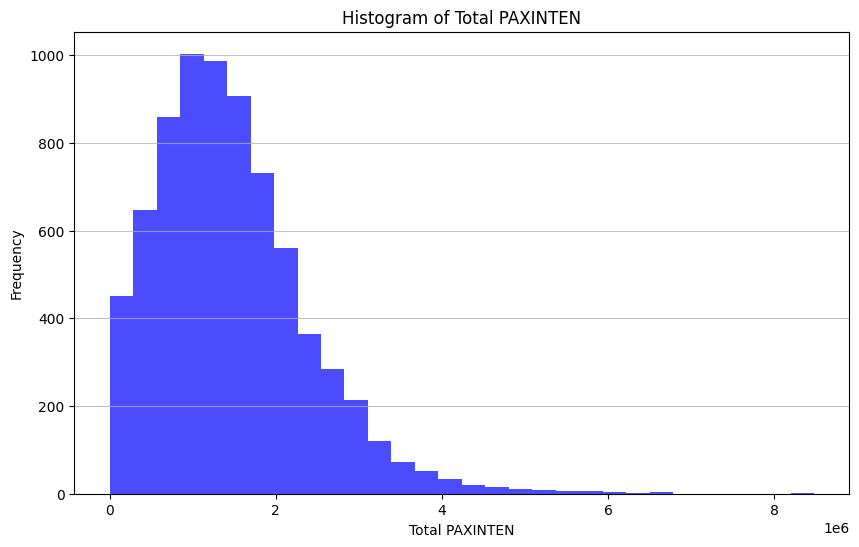

In [26]:
activity_sum_by_seqn = complete_activity_df.groupby('SEQN')['PAXINTEN'].sum().reset_index()
activity_sum_by_seqn.columns = ['SEQN', 'Total_PAXINTEN']

plt.figure(figsize=(10, 6))
plt.hist(activity_sum_by_seqn['Total_PAXINTEN'], bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Total PAXINTEN')
plt.xlabel('Total PAXINTEN')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [27]:
tenth_percentile = activity_sum_by_seqn['Total_PAXINTEN'].quantile(0.1)
acitivity_risk = activity_sum_by_seqn[activity_sum_by_seqn['Total_PAXINTEN'] <= tenth_percentile].SEQN

In [22]:
bmi_risk = complete_bmi_df.loc[complete_bmi_df['BMXBMI'] > 25, 'SEQN']

In [23]:
tv_risk = complete_tv_df.loc[complete_tv_df['PAD590'].isin([2,3,4,5]), 'SEQN']

In [24]:
cig_risk = complete_cig_df.loc[complete_cig_df['SMD057'].isin(range(20,96)), 'SEQN']

In [25]:
set_activity_risk = set(acitivity_risk)
set_bmi_risk = set(bmi_risk)
set_cig_risk = set(cig_risk)
set_tv_risk = set(tv_risk)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermedia

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

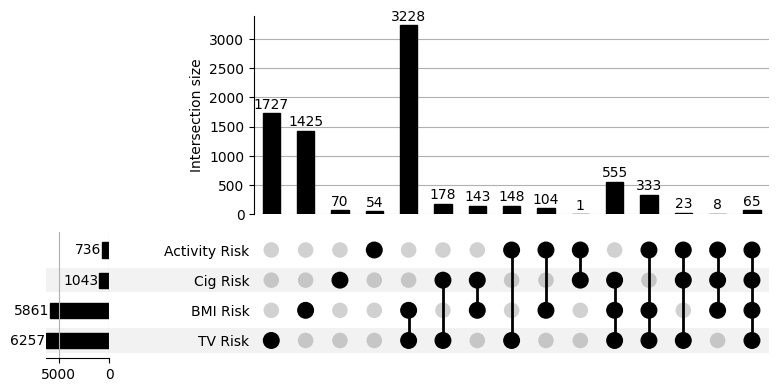

In [26]:
set_names = ['Activity Risk', 'BMI Risk', 'Cig Risk', 'TV Risk']
all_elems = set_activity_risk.union(set_bmi_risk).union(set_cig_risk).union(set_tv_risk)
df = pd.DataFrame([[e in set_activity_risk, e in set_bmi_risk, e in set_cig_risk, e in set_tv_risk] for e in all_elems], columns = set_names)
df_up = df.groupby(set_names).size()
plot(df_up, orientation='horizontal', show_counts=True)

In [33]:
len(pd.unique(activity_df['SEQN']))

9424

In [34]:
len(pd.unique(cig_df['SEQN']))

7186

In [35]:
len(pd.unique(bmi_df['SEQN']))

9950

In [36]:
len(pd.unique(demo_df['SEQN']))

10348

In [37]:
merged_df = demo_df.merge(bmi_df, on='SEQN', how='left')\
                  .merge(activity_df, on='SEQN', how='left')\
                  .merge(cig_df, on='SEQN', how='left')


In [38]:
# Variables
# PAD590: Hours watching TV
# PAD320: Moderate activity
# PAD200: Vigorous activity
# SMD057: Number of cigs
# BMXBMI: BMI
# RIDAGEYR: Age

In [39]:
merged_df = merged_df.rename(columns={
    'RIDAGEYR': 'Age',
    'BMXBMI': 'BMI',
    'PAD590': 'TV',
    'SMD057': 'Cigs',
    'PAD320': 'Moderate_Activity',
    'PAD200': 'Vigorous_Activity'})

In [40]:
merged_df[['SEQN','Age','BMI','TV','Cigs','Moderate_Activity','Vigorous_Activity']]

,SEQN,Age,BMI,TV,Cigs,Moderate_Activity,Vigorous_Activity
0,31127.0,0.0,NaN,NaN,NaN,NaN,NaN
1,31128.0,11.0,17.45,4.0,NaN,NaN,NaN
2,31129.0,15.0,26.53,3.0,NaN,1.0,1.0
3,31130.0,85.0,NaN,2.0,NaN,2.0,2.0
4,31131.0,44.0,30.90,2.0,NaN,2.0,2.0
...,...,...,...,...,...,...,...
10343,41470.0,0.0,NaN,NaN,NaN,NaN,NaN
10344,41471.0,12.0,18.41,3.0,NaN,1.0,1.0
10345,41472.0,34.0,26.23,4.0,NaN,2.0,1.0
10346,41473.0,21.0,26.16,1.0,NaN,2.0,1.0


In [41]:
merged_df.Cigs.isnull().mean()

0.8915732508697333

In [42]:
merged_df.BMI.isnull().mean()

0.135195206803247

In [43]:
merged_df.TV.isnull().mean()

0.09673366834170855

In [44]:
merged_df.Moderate_Activity.isnull().mean()

0.30894858909934286

In [45]:
merged_df.Vigorous_Activity.isnull().mean()

0.30894858909934286

In [46]:
merged_df['Vigorous_Binary'] = (merged_df['Vigorous_Activity'] == 1).astype(int)

In [47]:
merged_df['Moderate_Binary'] = (merged_df['Moderate_Activity'] == 1).astype(int)

In [48]:
merged_df['TV_Binary'] = ((merged_df['TV'] >= 2) & (merged_df['TV'] <= 5)).astype(int)

In [49]:
merged_df['BMI_Binary'] = (merged_df['BMI'] >= 30).astype(int)

In [50]:
merged_df['Cigs_Binary'] = (merged_df['Cigs'] > 20).astype(int)

In [51]:
merged_df['Effective_Age']  = merged_df.Age - (2*merged_df.Vigorous_Binary) - merged_df.Moderate_Binary + merged_df.TV_Binary + (3*merged_df.BMI_Binary) + (8*merged_df.Cigs_Binary)

In [52]:
merged_df[['Age', 'Effective_Age']]

,Age,Effective_Age
0,0.0,0.0
1,11.0,12.0
2,15.0,13.0
3,85.0,86.0
4,44.0,48.0
...,...,...
10343,0.0,0.0
10344,12.0,10.0
10345,34.0,33.0
10346,21.0,19.0


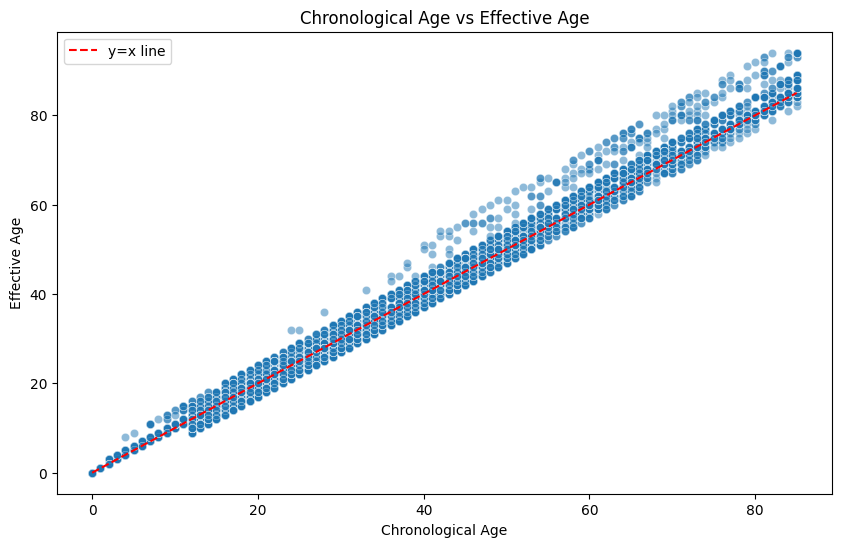

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='Age', y='Effective_Age', alpha=0.5)
plt.plot([0, merged_df['Age'].max()], [0, merged_df['Age'].max()], 'r--', label='y=x line')
plt.title('Chronological Age vs Effective Age')
plt.xlabel('Chronological Age')
plt.ylabel('Effective Age')
plt.legend()
plt.show()

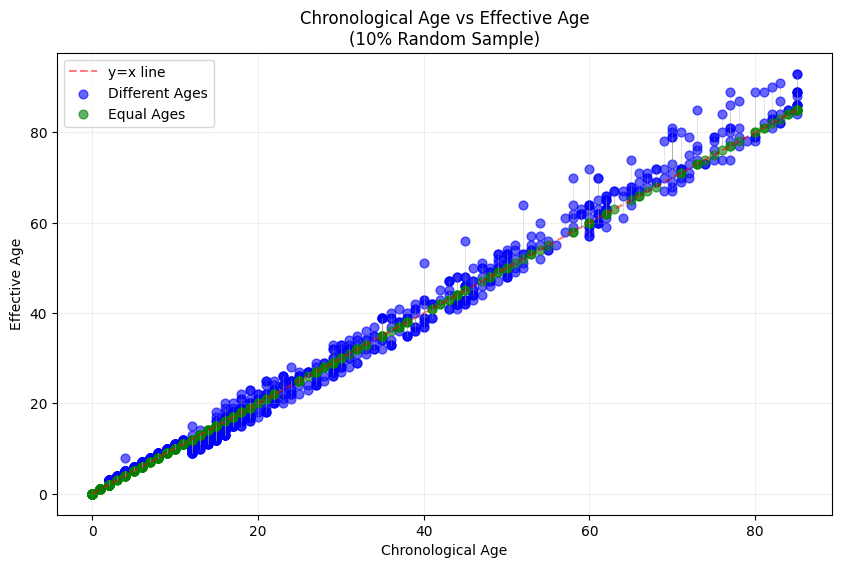

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Create a random 10% sample
sample_size = int(len(merged_df) * 0.1)
sampled_df = merged_df.sample(n=sample_size, random_state=42)  # random_state for reproducibility

# Create masks for equal and different ages
equal_ages = sampled_df['Age'] == sampled_df['Effective_Age']
different_ages = ~equal_ages

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the reference line first
plt.plot([0, merged_df['Age'].max()], [0, merged_df['Age'].max()], 'r--', label='y=x line', alpha=0.5)

# Plot vertical lines connecting points to the reference line
for _, row in sampled_df.iterrows():
    plt.plot([row['Age'], row['Age']], [row['Age'], row['Effective_Age']], 
             color='gray', alpha=0.3, linewidth=0.5)

# Plot points with different colors
plt.scatter(sampled_df[different_ages]['Age'], 
           sampled_df[different_ages]['Effective_Age'], 
           alpha=0.6, s=40, color='blue', label='Different Ages')

plt.scatter(sampled_df[equal_ages]['Age'], 
           sampled_df[equal_ages]['Effective_Age'], 
           alpha=0.6, s=40, color='green', label='Equal Ages')

plt.title('Chronological Age vs Effective Age\n(10% Random Sample)')
plt.xlabel('Chronological Age')
plt.ylabel('Effective Age')
plt.legend()

plt.grid(True, alpha=0.2)

plt.show()